In [1]:
! pip install scikit-dsp-comm
! pip install komm
! pip install sympy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 7.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 22.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56590 sha256=359bb26a4097697ee62e13f4cdb2abc42cf3a7dcb800fe2bed9814909b9f3716
  Stored in directory: /home/jovyan/.cache/pip/wheels/67/d6/14/a8e4b0235b3dc3c8a28c4e2059b66ad5b8c262df15df54f843
Successfully built

In [2]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import ipywidgets
from scipy.stats import binom

**Modulating pulses.  Select and plot in time and frequency one example of modulating pulses (signals) that are:**

**Time-limited**

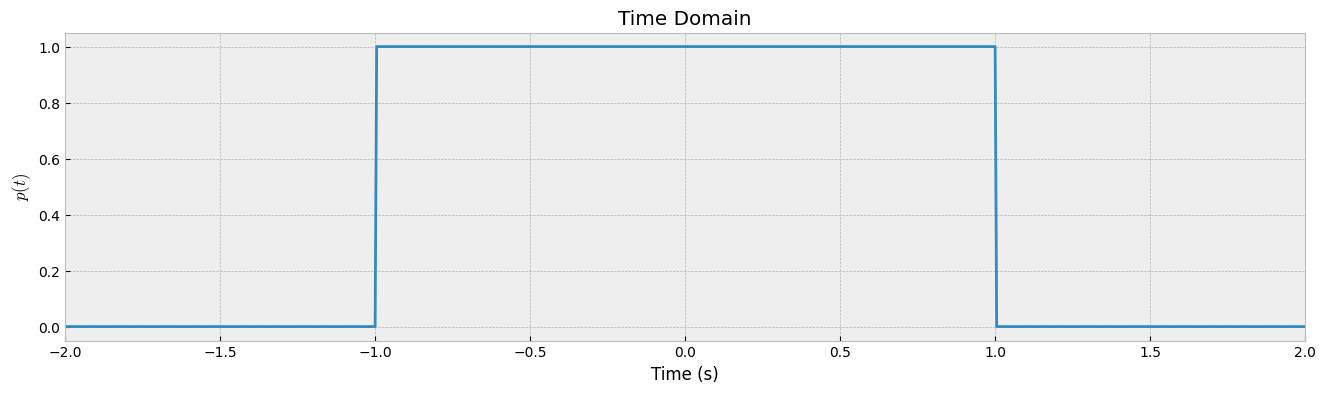

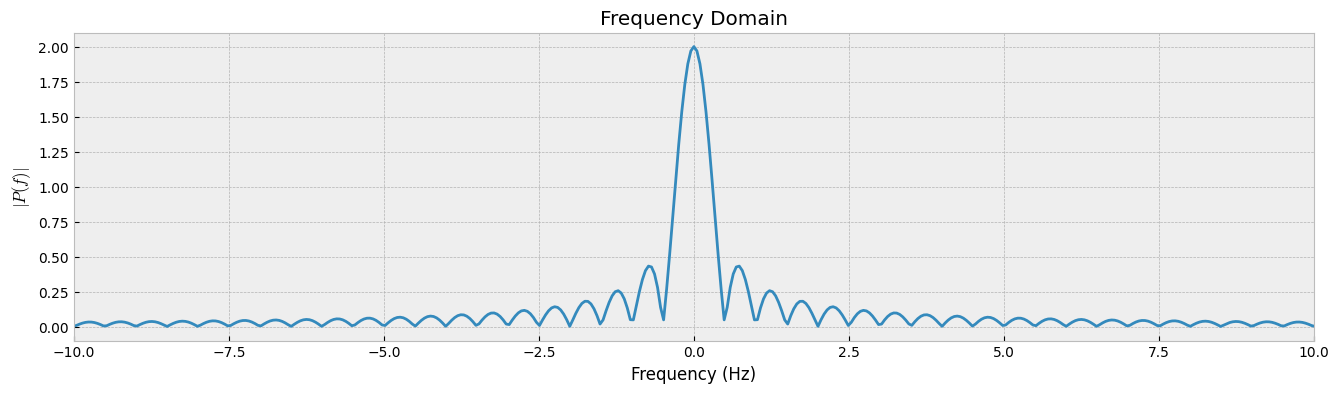

<Figure size 1600x400 with 0 Axes>

In [18]:
fs = 200 # sampling rate in Hz
###
t = np.arange(-5,5,1/fs)
x4 = ss.rect(t,2)
plt.figure(figsize=(16, 4))
plt.plot(t,x4);
#ylim([-1.1,1.1])
plt.xlim([-2,2])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');
f,X4 = ss.ft_approx(x4,t,4096)
plt.figure(figsize=(16, 4));
plt.plot(f,abs(X4));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');
plt.figure(figsize=(16, 4));

**Band-limited**

$$p(t) = 3\mathrm{cos}(2 \pi t) + 4\sin(6 \pi t)$$

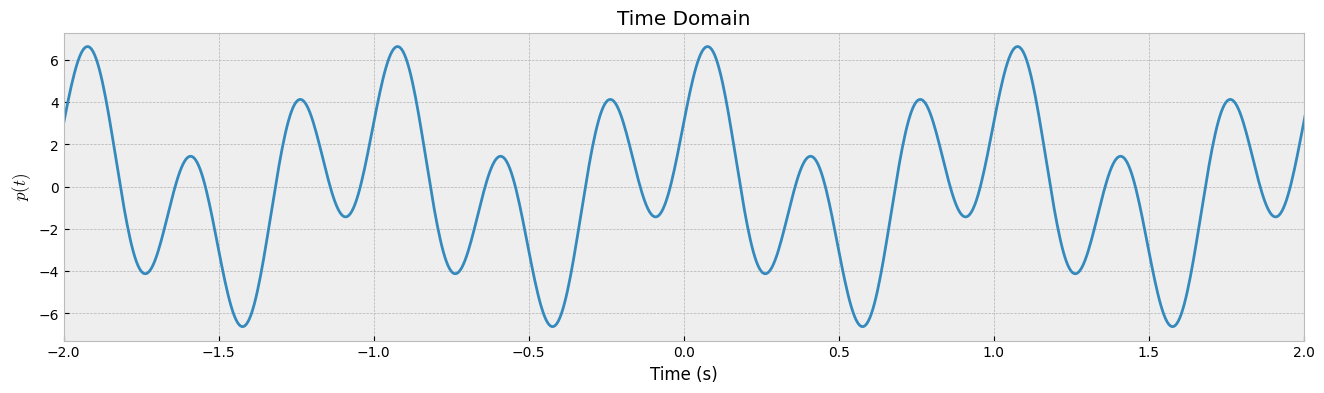

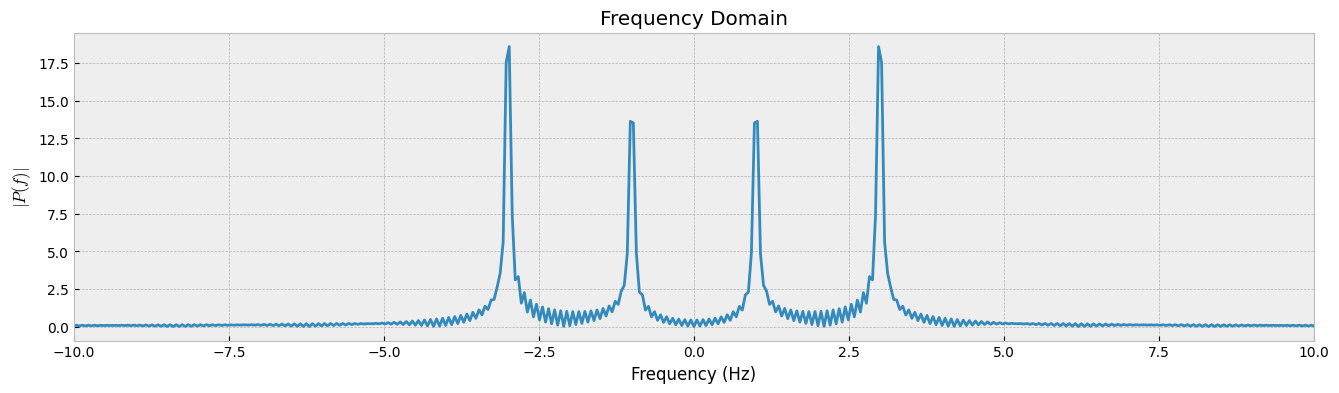

<Figure size 1600x400 with 0 Axes>

In [17]:
fs = 200
###
t = np.arange(-5,5,1/fs)
x4 = 3 * np.cos(2*np.pi*t) + 4*np.sin(6*np.pi*t) 
plt.figure(figsize=(16, 4))
plt.plot(t,x4);
#ylim([-1.1,1.1])
plt.xlim([-2,2])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');
f,X4 = ss.ft_approx(x4,t,4096)
plt.figure(figsize=(16, 4));
plt.plot(f,abs(X4));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');
plt.figure(figsize=(16, 4));

**Compare the performance in terms of symbol error probability of 2-PAM, 4-PAM, 4-QAM, 16-QAM, 64-QAM, 4-PSK, 8-PSK and 16-PSK in an AWGN channel with mean 0 and variance sigma = N_0/2 (per dimension).**

**Avarage symbol error probability $M = 2^k$**

$$M-PAM: P \approx 2 Q\left( \sqrt{\dfrac{6 k E_b}{(M^2-1) N_0}}\right) = 2 Q\left( \sqrt{\dfrac{6 E_s}{(M^2-1) N_0}}\right)$$

$$M-QAM: P \approx 4 Q\left( \sqrt{\dfrac{3 k E_b}{(M-1) N_0}}\right) = 4 Q\left( \sqrt{\dfrac{3 E_s}{(M-1) N_0}}\right)$$

$$M-PSK: P \approx 2 Q \left(\sqrt{\dfrac{2 k E_b}{N_0}} \sin\left(  \dfrac{\pi}{M} \right)  \right) = 2 Q \left(\sqrt{\dfrac{2 E_s}{N_0}} \sin\left(  \dfrac{\pi}{M} \right)  \right)$$

**Plot the SNR in dB vs. Symbol error probability for these values**

In [59]:
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

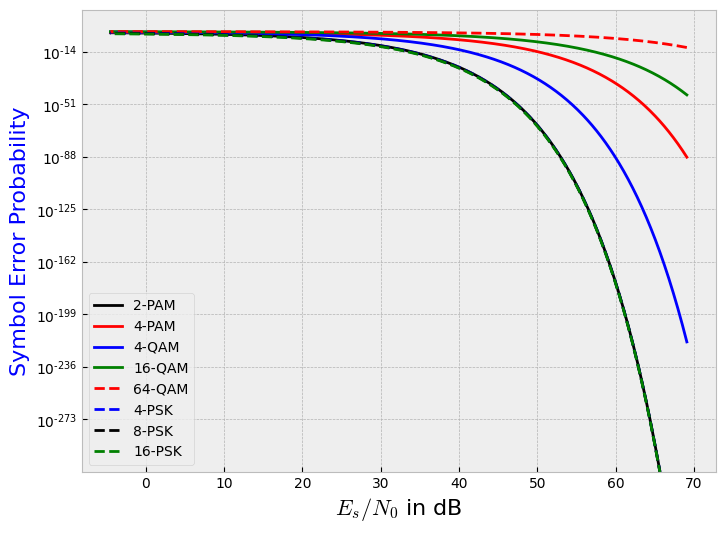

In [62]:
noise_power_db = np.arange(-30, 2, 0.05)
noise_power = 10**(noise_power_db / 10)
snr = 1/noise_power
awgn = komm.AWGNChannel()
###################################
#2-PAM
order = 2
error_probability_2pam = 2*Q(np.sqrt((6/(order**2-1))*snr))
base_amplitude = 1
modulation = komm.PAModulation(order, base_amplitude)
awgn.signal_power_2pam  = modulation.energy_per_symbol
awgn.snr_2pam  = awgn.signal_power_2pam  / noise_power
###################################
#4-PAM
order = 4
error_probability_4pam = 2*Q(np.sqrt((6/(order**2-1))*snr))
base_amplitude = 1
modulation = komm.PAModulation(order, base_amplitude)
awgn.signal_power_4pam  = modulation.energy_per_symbol
awgn.snr_4pam  = awgn.signal_power_4pam  / noise_power
###################################
#4-QAM
order = 4
error_probability_4qam = 4*Q(np.sqrt((3/(order-1))*snr))
base_amplitude = 1
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_4qam  = modulation.energy_per_symbol
awgn.snr_4qam  = awgn.signal_power_4qam  / noise_power
###################################
#16-QAM
order = 16
error_probability_16qam = 4*Q(np.sqrt((3/(order-1))*snr))
base_amplitude = 1
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_16qam  = modulation.energy_per_symbol
awgn.snr_16qam  = awgn.signal_power_16qam  / noise_power
###################################
#64-QAM
order = 64
error_probability_64qam = 4*Q(np.sqrt((3/(order-1))*snr))
base_amplitude = 1
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_64qam  = modulation.energy_per_symbol
awgn.snr_64qam  = awgn.signal_power_64qam  / noise_power
###################################
#4-PSK
order = 4
error_probability_4psk = 2*Q(np.sqrt(2*snr))*sp.sin(sp.pi/order)
base_amplitude = 1
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_4psk  = modulation.energy_per_symbol
awgn.snr_4psk  = awgn.signal_power_4psk  / noise_power
###################################
#8-PSK
order = 8
error_probability_8psk = 2*Q(np.sqrt(2*snr))*sp.sin(sp.pi/order)
base_amplitude = 1
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_8psk  = modulation.energy_per_symbol
awgn.snr_8psk  = awgn.signal_power_8psk  / noise_power
###################################
#16-PSK
order = 16
error_probability_16psk = 2*Q(np.sqrt(2*snr))*sp.sin(sp.pi/order)
base_amplitude = 1
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_12psk  = modulation.energy_per_symbol
awgn.snr_12psk  = awgn.signal_power_12psk  / noise_power
###################################
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log(snr), error_probability_2pam, 'k', label='2-PAM')
plt.semilogy(10 * np.log(snr), error_probability_4pam, 'r', label='4-PAM')
plt.semilogy(10 * np.log(snr), error_probability_4qam, 'b', label='4-QAM')
plt.semilogy(10 * np.log(snr), error_probability_16qam, 'g', label='16-QAM')
plt.semilogy(10 * np.log(snr), error_probability_64qam, 'r--', label='64-QAM')
plt.semilogy(10 * np.log(snr), error_probability_4psk, 'b--', label='4-PSK')
plt.semilogy(10 * np.log(snr), error_probability_8psk, 'k--', label='8-PSK')
plt.semilogy(10 * np.log(snr), error_probability_16psk, 'g--', label='16-PSK')
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()
plt.show()

**Compare these modulations in relation to the trade-off involved between spectral efficiency (bits/s/Hz) and bit error probability.**

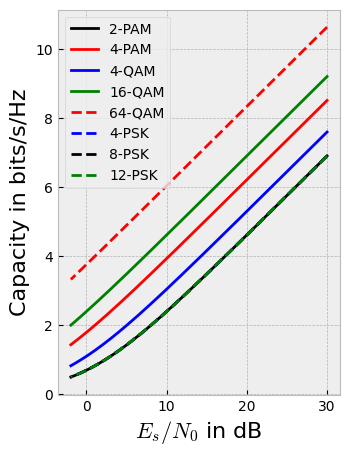

In [50]:
plt.subplot(122)
#plt.figure(1,figsize=(18,6))
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_2pam),'k',label='2-PAM');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_4pam),'r',label='4-PAM');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_4qam),'b',label='4-QAM');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_16qam),'g',label='16-QAM');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_64qam),'r--',label='64-QAM');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_4psk),'b--',label='4-PSK');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_8psk),'k--',label='8-PSK');
plt.plot(10 * np.log10(snr), np.log(1+awgn.snr_12psk),'g--',label='12-PSK');
plt.xlabel('$E_s/N_0$ in dB',fontsize=16);
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend();
plt.show()

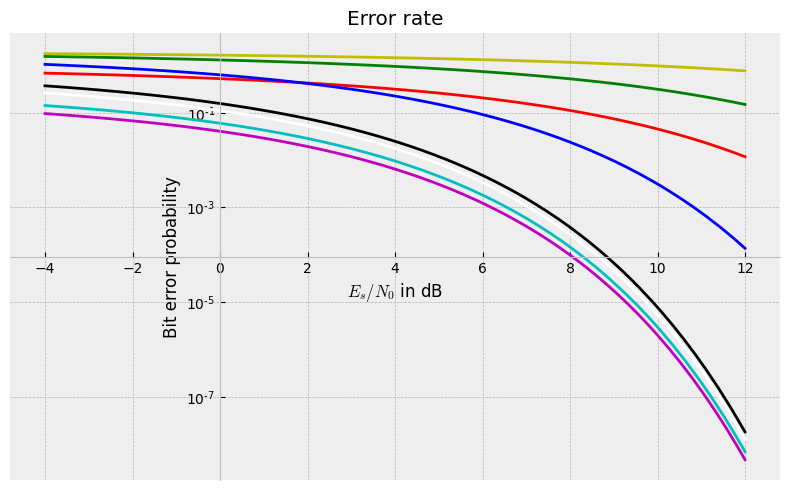

In [56]:
y = sp.Symbol("y")
def Q(x):
    return sp.simplify(1/2 * sp.erfc(x/sp.sqrt(2)))

plt.rcParams['figure.figsize'] = 8, 5
plot_aux = sp.plot(sp.N(2*Q(sp.sqrt((6/(2**2-1))* 10**(y/10)))), 
                   sp.N(2*Q(sp.sqrt((6/(4**2-1))* 10**(y/10)))),
                   sp.N(4*Q(sp.sqrt((3/(4-1))* 10**(y/10)))),
                   sp.N(4*Q(sp.sqrt((3/(16-1))* 10**(y/10)))),
                   sp.N(4*Q(sp.sqrt((3/(64-1))* 10**(y/10)))),
                   sp.N(2*Q(sp.sqrt(2* 10**(y/10)))*sp.sin(sp.pi/4)),
                   sp.N(2*Q(sp.sqrt(2* 10**(y/10)))*sp.sin(sp.pi/8)),
                   sp.N(2*Q(sp.sqrt(2* 10**(y/10)))*sp.sin(sp.pi/12)),
                   (y,-4,12),xlabel='$E_s/N_0$ in dB',ylabel='Bit error probability', yscale= 'log', title='Error rate',show=False);
plot_aux[0].line_color = 'k' #black
plot_aux[1].line_color = 'r' #red
plot_aux[2].line_color = 'b' #blue
plot_aux[3].line_color = 'g' #green
plot_aux[4].line_color = 'y' #yellow
plot_aux[5].line_color = 'w' #white
plot_aux[6].line_color = 'c' #cyan
plot_aux[7].line_color = 'm' #magenta/purple
plot_aux.show()

**What is the capacity of this channel by plotting the curve of the Channel Capacity as a function of SNR.**

Text(0.02, 0.075, 'Achievable rates')

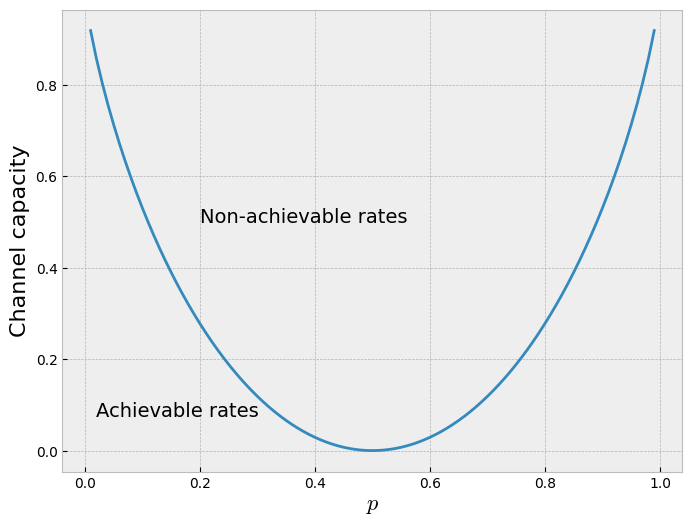

In [17]:
error_prob = np.arange(0,1,0.01);
capacity_bsc = np.zeros(len(error_prob));
for i in range(len(error_prob)):
    capacity_bsc[i] = komm.BinarySymmetricChannel(error_prob[i]).capacity()
plt.rcParams['figure.figsize'] = 8, 6
plt.plot(error_prob,capacity_bsc);
#plt.fill_between(error_prob, 0, capacity_bsc);
plt.xlabel('$p$',fontsize=16);
plt.ylabel('Channel capacity',fontsize=16);
plt.text(0.2,0.5,'Non-achievable rates',fontsize=14)
plt.text(0.02,0.075,'Achievable rates',fontsize=14)

**With your own words, how you could improve the performance in relation to symbol-error rate and bit-error rate? (error rate and error probability mean the same thing here). Is it possible to know how good is your solution?**

Performance could be improved by favoring 2-PAM and PSK's as those have lower error-probability. Another way could be increasing SNR value as it can lower error-probability. Efficiency of this solution could be measured by plotting in graph. Example below (with SNR value doubled)

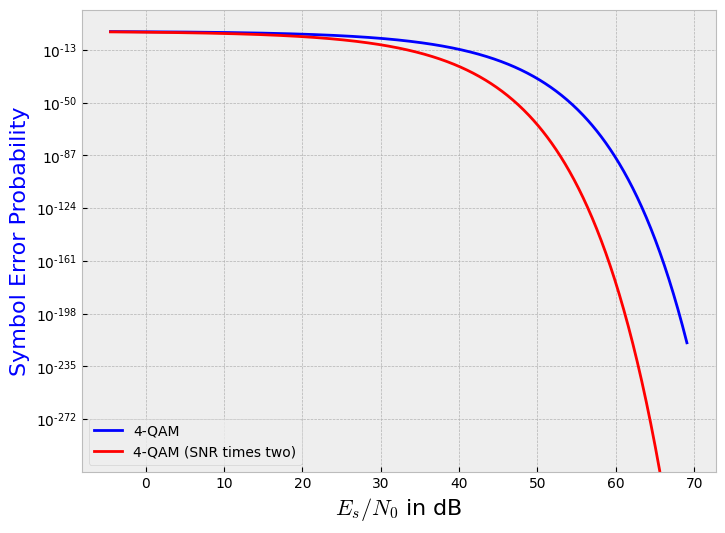

In [64]:
###################################
#4-QAM
order = 4
error_probability_4qam = 4*Q(np.sqrt((3/(order-1))*snr))
base_amplitude = 1
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_4qam  = modulation.energy_per_symbol
awgn.snr_4qam  = awgn.signal_power_4qam  / noise_power
###################################
#4-QAM (double snr)
order = 4
error_probability_4qam2 = 4*Q(np.sqrt((3/(order-1))*2*snr))
base_amplitude = 1
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_4qam  = modulation.energy_per_symbol
awgn.snr_4qam  = awgn.signal_power_4qam  / noise_power
###################################
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log(snr), error_probability_4qam, 'b', label='4-QAM')
plt.semilogy(10 * np.log(snr), error_probability_4qam2, 'r', label='4-QAM (SNR times two)')
plt.xlabel('$E_s/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()
plt.show()